# Kernel Density Estimation

In this homework, you will learn about Kernel Density Estimation (KDE), a non-parametric way to estimate the probability density function of a random variable.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

<ipython-input-1-cd9e54b682e8>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Motivating Kernel Density Estimation: Histograms

We discussed that a density estimator aims to model the underlying probability distribution from which a dataset originates. In the case of one-dimensional data, a common and straightforward density estimator you might know is the histogram. This technique segregates the data into distinct bins, calculates the number of data points in each bin, and subsequently presents the outcome in an easily understandable way.

For instance, let's generate data from two Gaussian distributions:

In [ ]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the `plt.hist` function.
By specifying the `density` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density (see the following figure):

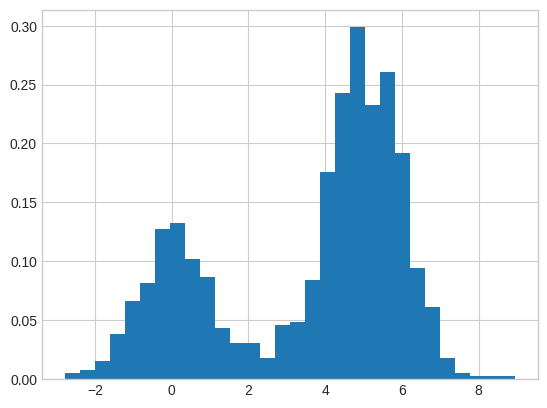

In [ ]:
hist = plt.hist(x, bins=30, density=True)

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts.
This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

In [ ]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.
For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!
Consider this example, visualized in the following figure:

In [ ]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

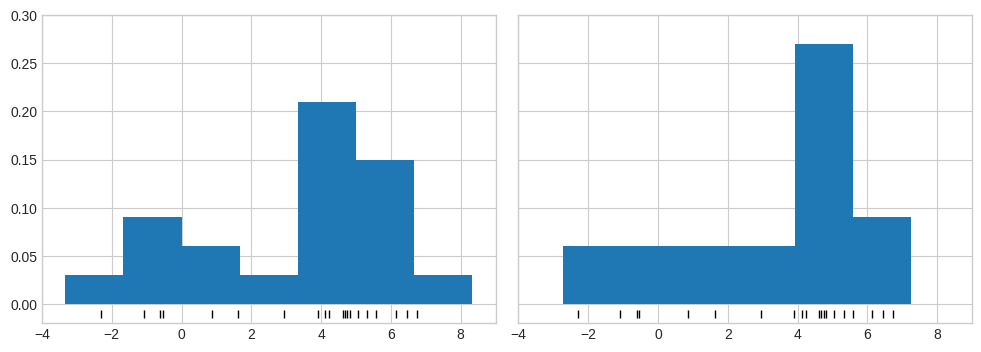

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution.
On the right, we see a unimodal distribution with a long tail.
Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data. With that in mind, how can you trust the intuition that histograms confer?
And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.
Let's view this directly (see the following figure):

(-0.2, 8.0)

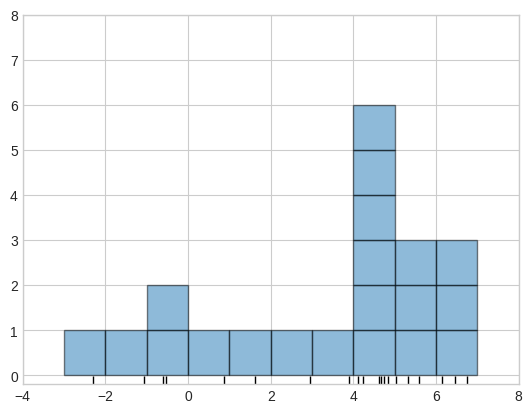

In [ ]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle(
            (edge, i), 1, 1, ec='black', alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binnings stems from the fact that the height of the block stack often reflects not the actual density of points nearby, but coincidences of how the bins align with the data points.
This misalignment between points and their blocks is a potential cause of the poor histogram results seen here. In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian.
Let's use a standard normal curve at each point instead of a block:

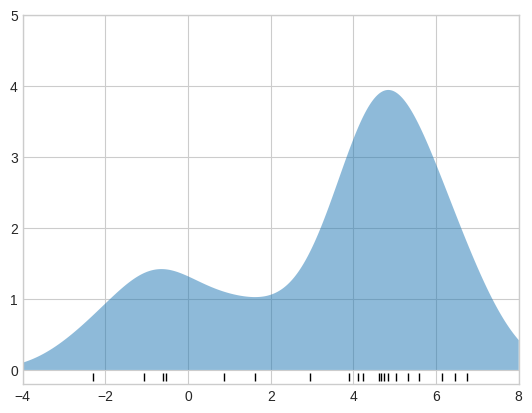

In [ ]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one that has much less variance (i.e., changes much less in response to differences in sampling).

What we've landed on in the last two plots is what's called kernel density estimation in one dimension: we have placed a "kernel"—a square or "tophat"-shaped kernel in the former, a Gaussian kernel in the latter—at the location of each point, and used their sum as an estimate of density.
With this intuition in mind, we'll now explore kernel density estimation in more detail.

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for kernel density estimation but in this example, we will use the guassian kernel.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
x = make_data(1000)

# Points at which to evaluate the density
x_d = np.linspace(min(x) - 1, max(x) + 1, 100)


In [ ]:
# Gaussian kernel function
def gaussian_kernel(x, h=1.0):
  # problem 1
    gaussian_value = (1 / np.sqrt(2*np.pi*h**2)) * np.exp(-(x**2 / 2*h**2))

    return gaussian_value

# KDE function
def kde(x, data, h=1.0):
  # problem 2 f(x)
    density_estimate = np.zeros_like(x)

    for y in data:
        kernel_value = gaussian_kernel(x-y, h)
        density_estimate +=kernel_value #커널을 중첩

    density_estimate = density_estimate/(len(data)*h)

    return density_estimate

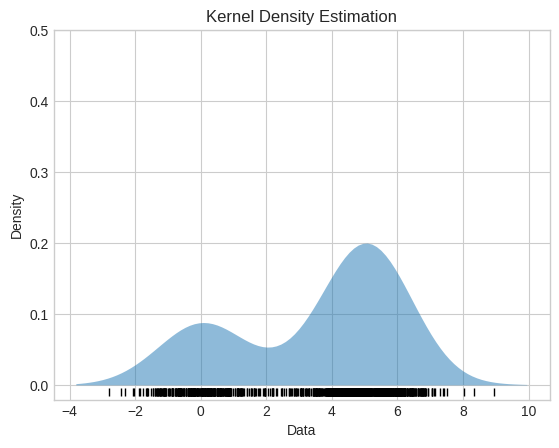

In [ ]:
# Fit the KDE model and evaluate at points x_d
h = 1.0  # Bandwidth
density_at_xd = kde(x_d, x, h=h)  #f(xd)

# Plot the results
plt.fill_between(x_d, density_at_xd, alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.5)
plt.xlabel("Data")
plt.ylabel("Density")
plt.title("Kernel Density Estimation")
plt.show()


The result here is normalized such that the area under the curve is equal to 1.